# Dataset Information
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

In [9]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
from subprocess import call
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
%matplotlib inline

In [10]:
print("Downloading...")
if not os.path.exists("UCI HAR Dataset.zip"):
    call('wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip"', shell=True)
    print("Downloading done.\n")
else:
    print("Dataset already downloaded. Did not download twice.\n")

print("Extracting...")
extract_directory = os.path.abspath("UCI HAR Dataset")
if not os.path.exists(extract_directory):
    call('unzip -nq "UCI HAR Dataset.zip"', shell=True)
    print("Extracting successfully done to {}.".format(extract_directory))
else:
    print("Dataset already extracted. Did not extract twice.\n")

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.



In [11]:
ACTIVITIES = {0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING'}
SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]
DATADIR = 'UCI HAR Dataset'

In [12]:
def read_csv_file(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

In [15]:
def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = f'UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(read_csv_file(filename).values) 
    return np.transpose(signals_data, (1, 2, 0))

In [14]:
def load_label(subset):
    filename = f'UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = read_csv_file(filename)[0]
    return pd.get_dummies(y).values

In [16]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_label('train'), load_label('test')
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, Y_train, Y_test = load_data()

In [18]:
print(f"train data shape is : {X_train.shape[0]}X{X_train.shape[1]}X{X_train.shape[2]}")
print(f"test data shape is : {X_test.shape[0]}X{X_test.shape[1]}X{X_test.shape[2]}")
print(f"train data shape is : {Y_train.shape[0]}X{Y_train.shape[1]}")
print(f"test data shape is : {Y_test.shape[0]}X{Y_test.shape[1]}")

train data shape is : 7352X128X9
test data shape is : 2947X128X9
train data shape is : 7352X6
test data shape is : 2947X6


In [19]:
np.random.seed(42)
tf.set_random_seed(42)

In [20]:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [21]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [22]:
epochs = 30
batch_size = 16
n_hidden = 32

In [23]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [24]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [26]:
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7344/7352 [============================>.] - ETA: 0s - loss: 1.1966 - acc: 0.5074

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7352/7352 [==============================] - 10s 1ms/sample - loss: 1.1965 - acc: 0.5072 - val_loss: 1.0115 - val_acc: 0.5826
Epoch 2/30
7352/7352 [==============================] - 9s 1ms/sample - loss: 0.7557 - acc: 0.7039 - val_loss: 0.7338 - val_acc: 0.7146
Epoch 3/30
7352/7352 [==============================] - 9s 1ms/sample - loss: 0.6353 - acc: 0.7428 - val_loss: 0.6440 - val_acc: 0.7801
Epoch 4/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.5714 - acc: 0.7708 - val_loss: 0.6450 - val_acc: 0.7784
Epoch 5/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.5340 - acc: 0.7874 - val_loss: 0.7425 - val_acc: 0.7224
Epoch 6/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.4099 - acc: 0.8538 - val_loss: 0.5065 - val_acc: 0.8229
Epoch 7/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.3339 - acc: 0.8934 - val_loss: 0.5773 - val_acc: 0.8320
Epoch 8/30
7352/7352 [==============================] 

In [29]:
import seaborn as sns
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return sns.heatmap(pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred']), annot=True)

AxesSubplot(0.125,0.125;0.62x0.755)


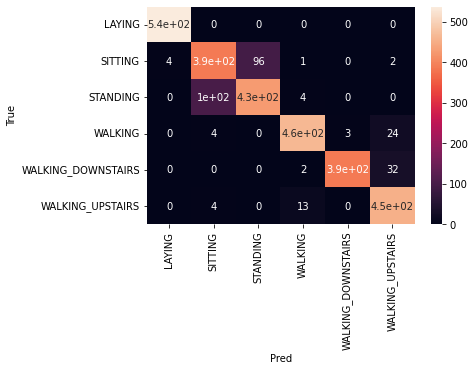

In [30]:
print(confusion_matrix(Y_test, model.predict(X_test)))

In [31]:
score = model.evaluate(X_test, Y_test)

In [32]:
score

[0.3596688051601745, 0.9012555]